 ### PINNs for solving the wave equation (forward problem). 
The goal of the forward problem is to compute the wave field $p(x,y,t)$ that satisfies the wave equation with source term $s(x,y,t)$,
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = s.$$
We start by assuming that the speed of sound in the medium, $c(x,y)$, is known. Without loss of generality, we define $ s(x,y,t) \equiv 0 $, and introduce the source(s) as an initial perturbation at an early time.  

The inference of $p(x,y,t)$ will be based on:
- The initial condition
- The physics via the undelying PDE

We will use physics-informed neural networks (PINNs) for the task of estimating $p$. 

By Samuel A. Verburg, saveri@dtu.dk. This notebook was inspired by [Moseley 2020] and [Rasht-Behesht 2022] (see a list of references at the end).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from PINNs_util.PINNs_fdiff import solver
from PINNs_util.PINNs_aux import FCN,\
                        xyt_tensor,\
                        pde_residual,\
                        update_lambda,\
                        rand_colloc
from PINNs_util.PINNs_plots import plot_train_log,\
                        plot_field,\
                        plot_estimation,\
                        plot_speed

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Problem setup
We start by defining a 2+1D domain. The spatial domain is a square of side length $L=5$ km, and the time domain has a duration $T=1.3$ s. The maxium speed of sound is $c_0=3$ km/s. The source is modelled as a Gaussian pulse of width `gpulse_std`, centered at `r_source`.

It is important to scale the dimensions of the domain so that none of the terms in the PDE is very large or very small. For details on this see *section 3. Non-dimensionalization* in [Wang 2023] https://doi.org/10.48550/arXiv.2308.08468 and the book *Scaling of Differential Equations* by Langtangen and Pedersen. 

To simulate the wave propagation, we use a python implementation of the finite difference method based on Langtangen's book "Finite Difference Computing with PDEs" https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/index.html. We compute and plot the reference solution.

100%|██████████| 55/55 [00:00<00:00, 3725.98it/s]


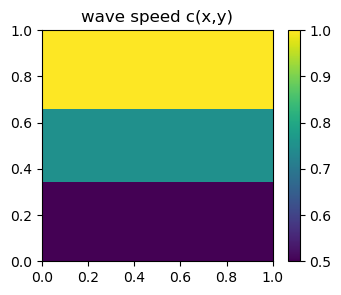

100%|██████████| 110/110 [00:00<00:00, 2492.40it/s]


In [53]:
# define domain
L = 5
T = 1.3
c0 = 3

# scaling
T = T*c0/L
L = L/L
c0 = 1

# wave speed
def c(xx, yy, tensor=False):
    if tensor:
        c = 0.5*torch.ones_like(xx, device=device)
    else:
        c = 0.5*np.ones_like(xx)
    ind = yy >= 0.33
    c[ind] = 0.75
    ind = yy >= 0.66
    c[ind] = 1
    return c

# initial condition
def I(xx, yy):
    I = np.zeros_like(xx)
    # pulse
    gpulse_std = 5e-2
    r_pulse = np.array([0.5, 0.5])
    I = np.exp(-0.5*( ((xx-r_pulse[0])/gpulse_std)**2 +\
                      ((yy-r_pulse[1])/gpulse_std)**2 ))
    return I

# solve
Lx, Ly = L, L
Nx, Ny = 50, 50
dt = -1
p_ref, xx, yy, t, dt = solver(I, 0, 0, c, Lx, Ly, Nx, Ny, dt, T)
p_ref, xx, yy, t = p_ref.astype(np.float32), xx.astype(np.float32), yy.astype(np.float32), t.astype(np.float32)

# we need tensors
xy = np.column_stack((np.reshape(xx,(-1,1)), np.reshape(yy,(-1,1))))
r_ref = xyt_tensor(xy, t, device)
n_T = t.shape[0]
n_L = xx.shape[0]

# plot wave speed 
plot_speed(c(xx, yy), L)

# plot high res reference field (it might take a few seconds)
p_plot,_,_,_,_ = solver(I, 0, 0, c, Lx, Ly, int(Nx*2), int(Ny*2), -1, T)
ani = plot_field(p_plot, L, 'wave field (high res plot)')
ani

### Initial condition
We assume that we know the position, propagation direction, and shape of the source. This is enconded in early-time snapshots of the wave field (see [Rasht-Behesht 2022] https://doi.org/10.1029/2021JB023120). Here we consider that the source is encoded in the first 10 steps of the numerical solver, which we call `p_ini`. With this information we are ready to train our PINN. 

In [ ]:
# Initial condition
n_ini = 10
t_ini = t[0:n_ini]
r_ini = xyt_tensor(xy, t_ini, device)
p_ini = p_ref[:,:,:n_ini].reshape(-1,1)
p_ini = torch.tensor(p_ini, device=device)

### PINN
We start with a fully-connected neural network with 3 inputs, $(x,y,t)$, and 1 output, $p$. We define the number of hidden units per layer, `n_hidden`, and the number of layers, `n_layers`. 

 #### Fourier features
 Neural networks (not only PINNs) struggle to learn the high-frequency content of functions. This is sometmes called the NN 'spectral bias'. High-frequencies can be associated, for example, to function discontinuities or jumps, such as edges in an image (here are some great examples in image processing https://bmild.github.io/fourfeat/). In order to alleviate this issue [Tancik 2020]
 https://doi.org/10.48550/arXiv.2006.10739 proposed a simple Fourier mapping $\gamma(\mathbf{r})$ of the inputs of the network. Later on, Fourier features have also been applied to PINNs to approximate solutions to PDEs with high frequencies and multi-scale features [Wang 2021b] https://doi.org/10.1016/j.cma.2021.113938 In its original formulation, the Fourier mapping is computed as

 $$ \gamma(\mathbf{r}) = \begin{bmatrix} \cos(\mathbf{Br})\\ \sin(\mathbf{Br})\end{bmatrix} $$

where $\mathbf{B}$ is a matrix with dimensions `n_in` x `n_ffeatures`. The entries of $\mathbf{B}$ are sampled from a normal distribution with std $\sigma$.  It was shown, however, that the choice of $\sigma$ is not straight forward since it depends on the frequency content of the function to be approximated. Here we change the formulation slightly, and compute the Fourier mapping as 

 $$ \gamma(\mathbf{r}) = \cos(\mathbf{Br + b}) $$

 where $\mathbf{B}$ and $\mathbf{b}$ are treated as network parameters so that they will be learned during training . Note that this is very similar to the SIREN activation function [Sitzmann 2020]     
 https://doi.org/10.48550/arXiv.2006.09661. In our case we just apply it to the input as a first layer.

 To test the Fourier features let's train the network only on the initial conditions. Notice that we *know* the first snapshots, so the network shouldn't have much trouble learning that. Lets train first a network without Fourier mapping.  

In [54]:
n_in = 3
n_out = 1
n_ffeatures = 0
n_hidden = 64
n_layers = 3
n_epochs = int(5e3)

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    loss = mse_loss(p, p_ini)

    # backpropagate
    loss.backward()
    optimiser.step()

# Plot reference and estimation
print('Estimation without Fourier Features - loss', str(np.round(loss.item()*1e6,3))+'*e-6')
p_est = model(r_ini)
p_est = p_est.cpu().detach().numpy()
ani = plot_estimation(p_ref[:,:,:n_ini], p_est, L)
ani

100%|██████████| 5000/5000 [00:10<00:00, 478.33it/s]


Estimation without Fourier Features - loss 1291.715*e-6


It's clear that after 5000 epochs the NN has only learned the low frequency content of the initial conditions.
Let's see what happens when we use the Fourier mapping. 

In [55]:
n_ffeatures = 64

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    loss = mse_loss(p, p_ini)

    # backpropagate
    loss.backward()
    optimiser.step()

# Plot reference and estimation
print('Estimation with Fourier Features - loss', str(np.round(loss.item()*1e6,3))+'*e-6')
p_est = model(r_ini)
p_est = p_est.cpu().detach().numpy()
ani = plot_estimation(p_ref[:,:,:n_ini], p_est, L)
ani

100%|██████████| 5000/5000 [00:13<00:00, 366.55it/s]


Estimation with Fourier Features - loss 6.177*e-6


One can see that the Fourier mapping helps to estimate the high frequencies present in the initial condition.
### Loss function
The loss function $\mathcal{L}$ is defined as a weighted sum of an initial condition term, $\mathcal{L}_\text{ini}$, and a physics term, $\mathcal{L}_\text{pde}$, so that the total loss is
$$
\mathcal{L} = \lambda_\text{ini}\mathcal{L}_\text{ini} + \lambda_\text{pde}\mathcal{L}_\text{pde}
$$
This is a 'soft-constrained' formulation, meaning that the conditions (pde, initial) are not enforced in a hard way. This soft-constrained PINN is easy to formulate, but on the downside the learned function might not satisfy the conditions exactly.

The choice of the weights $\lambda = [\lambda_\text{ini}, \lambda_\text{pde}]$ can be a delicate one. One can choose it 'manually' by trying out different values and keeping the one that give reasonable results. However manually finding a $\lambda$ that balances the relative weight of the loss terms properly can be very tricky and tedious (specially when we have a loss composed by more than two terms). 

Here we implement an anneling algorithm to automatically choose $\lambda$, as proposed in [Wang 2021] https://doi.org/10.48550/arXiv.2001.04536. PINNs are notoriously difficult to train, one of the reasons being that the gradients (wrt to the network parameters $\theta$) of the different terms in the loss function can be very different. This unbalance can lead to unstable gradient descent during traning. As a way to alleviate this, $\lambda$ is chosen based on the gradient of each of the loss terms.
The algorithm is summarized as: 

if (`i_epoch` mod `n_lamb_update`) = 0 compute:
$$ \hat{\lambda}_\text{ini} = \frac{||\nabla_\theta \mathcal{L}_\text{ini}|| + ||\nabla_\theta \mathcal{L}_\text{pde}||} {||\nabla_\theta \mathcal{L}_\text{ini}||} $$

$$ \hat{\lambda}_\text{pde} = \frac{||\nabla_\theta \mathcal{L}_\text{ini}|| + ||\nabla_\theta \mathcal{L}_\text{pde}||} {||\nabla_\theta \mathcal{L}_\text{pde}||} $$

Then update the weights using a moving average with parameter $\alpha$:
$$ \lambda_\text{new} = \alpha \lambda_\text{old} + (1-\alpha)\hat{\lambda}_\text{new}$$

### Causal training
curriculum learning

In [ ]:
n_in = 3
n_out = 1
n_ffeatures = 64
n_hidden = 64
n_layers = 3
n_lamb_update = 100
n_colloc = int(1e4)

n_causal = int(2e3)
n_epochs = int(n_causal*(n_T-1))

lamb = [1, 1]

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

loss_ini_hist = []
loss_pde_hist = []
lamb_ini_hist = []
lamb_pde_hist = []

In [ ]:
print('Traning PINN...')
i_causal = 0

for i in tqdm(range(n_epochs)):

    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    loss_ini = mse_loss(p, p_ini)

    if i % n_causal == 0:
        i_causal += 1
    # pde loss
    r_colloc = rand_colloc(n_colloc, L, t[i_causal], device)
    c_colloc = c(r_colloc[:,0:1],r_colloc[:,1:2],tensor=True)
    p = model(r_colloc)
    pde_res = pde_residual(p, r_colloc, c_colloc)
    loss_pde = mse_loss(pde_res, torch.zeros_like(p))

    loss_lst = [loss_ini, loss_pde]

    # get gradients and update lambda
    if i % n_lamb_update == 0: 
        lamb = update_lambda(model, loss_lst, lamb, 0.9)

    # total loss
    loss = loss_ini +\
            loss_pde*lamb[1]/lamb[0]

    # backpropagate
    loss.backward()
    optimiser.step()

    # log
    loss_pde_hist.append(loss_pde.item())
    loss_ini_hist.append(loss_ini.item())
    lamb_ini_hist.append(lamb[0].item())
    lamb_pde_hist.append(lamb[1].item())

    if i % 10000 == 9999:
        # print loss
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss.item()*1e3))


Save the trained models.

In [ ]:
# save the trained model and loss log
# path = "./PINNs_util/trained_models/forward/"
# torch.save(model.state_dict(), path+"model.pt")

# loss = [loss_ini_hist, loss_pde_hist]
# lamb = [lamb_ini_hist, lamb_pde_hist]

# torch.save(loss, path+"loss.pt")
# torch.save(lamb, path+"lamb.pt")

Instead of waiting for the NN to train, you can load the pre-trained model by uncommenting and running the next cell.

In [56]:
path = "./PINNs_util/trained_models/forward/"
model.load_state_dict(torch.load(path+"model.pt", weights_only=True))
model.eval()
model.to(device)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

loss = torch.load(path+"loss.pt", weights_only=True)
lamb = torch.load(path+"lamb.pt", weights_only=True)

Model's state_dict:
B 	 torch.Size([3, 64])
b 	 torch.Size([1, 64])
fcs.0.weight 	 torch.Size([64, 64])
fcs.0.bias 	 torch.Size([64])
fch.0.0.weight 	 torch.Size([64, 64])
fch.0.0.bias 	 torch.Size([64])
fch.1.0.weight 	 torch.Size([64, 64])
fch.1.0.bias 	 torch.Size([64])
fce.weight 	 torch.Size([1, 64])
fce.bias 	 torch.Size([1])


Plot loss terms and lambdas as a function of epochs.

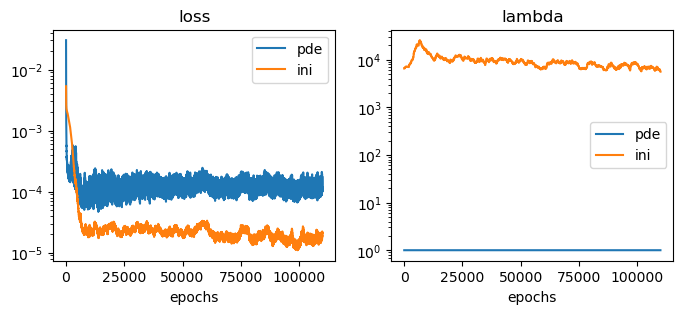

In [57]:
# Plot loss and lambda
label = ["ini", "pde"]
plot_train_log(loss, lamb, label)

Plot reference and estimated fields. 

In [58]:
# Plot reference and estimation
p_est = model(r_ref)
p_est = p_est.cpu().detach().numpy()
ani = plot_estimation(p_ref, p_est, L)
ani

Since we leaned a continuous function, we can estimate the pressure at arbitrary $x,y,t$ in the domain. 

In [59]:
t_hr = np.linspace(0, T, n_T*2).astype(np.float32)
r_hr = np.linspace(0, L, n_L*2).astype(np.float32)

x_hr, y_hr = np.meshgrid(r_hr, r_hr)
r_hr = np.column_stack((np.reshape(x_hr,(-1,1)), np.reshape(y_hr,(-1,1))))
r_hr = xyt_tensor(r_hr, t_hr, device)

p_est = model(r_hr)
p_est = np.reshape(p_est.cpu().detach().numpy(), (n_L*2, n_L*2, n_T*2))
ani = plot_field(p_est, L, 'high res estimation')
ani